# Mortality Data Analysis

### Preprocessing

In [19]:
#File loading method stack overflow link: https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
#All dataframe methods learned from pandas documentation
#np.where learned from numpy documentation

import numpy as np
import pandas as pd
import glob
import os
import pickle
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score
from sklearn import preprocessing
import matplotlib.pyplot as plt


filename = 'MortalityCondensed.csv'
pd.set_option('display.max_columns',500)
pd.options.mode.chained_assignment = None 

def process_files(local_path):
    #Load all .csv files in the mortality directory
    all_files = glob.glob(local_path + "/*.csv")
    dataframe = pd.DataFrame()
    file_list = []

    for file in all_files:
        
        df = pd.read_csv(file, index_col = None, header = 0, low_memory = False)
        dfInterest = df[['sex','race','detail_age','month_of_death', 'manner_of_death', 'education_2003_revision','education_1989_revision']] #Isolate columns we need
        dfInterest['binary_male'] = np.where(dfInterest['sex']=='M', 1, 0)
        dfInterest['binary_suicide'] = np.where(dfInterest['manner_of_death']==2, 1, 0) #create the binary suicide column
        
        #Recode education to get rid of NaNs. Code 18 represents where we have no data.
        #dfInterest['education_1989_revision'] = np.where(dfInterest['education_1989_revision'] <= 8, 1, dfInterest['education_1989_revision'])
        #dfInterest['education_recode'] = np.where(type(dfInterest['education_2003_revision'])==str, dfInterest['education_1989_revision'], dfInterest['education_2003_revision'])
        #dfInterest['education_recode'] = np.where(type(dfInterest['education_recode'])==str, 18, dfInterest['education_recode'])
        
        #Recode race to give us more meaningful categories 0 hispanic, 1 white, 2 black, 3 asian
        dfInterest['binary_white'] = np.where(dfInterest['race'] == 1, 1, 0)
        dfInterest['binary_black'] = np.where(dfInterest['race'] == 2, 1, 0)
        dfInterest['binary_asian'] = np.where(dfInterest['race'] > 2, 1, 0)
        dfInterest['binary_hispanic'] = np.where(dfInterest['race'] == 0, 1, 0)

        file_list.append(dfInterest) #add the new dataframe to the list

    dataframe = pd.concat(file_list) #concat the whole list to the final dataframe
    finaldf = dataframe.drop(columns=['race', 'sex','education_2003_revision','education_1989_revision'])
    
    # Reordering
    finaldf = finaldf[['binary_male', 'binary_white', 'binary_black', 'binary_asian', 'binary_hispanic',
                       'detail_age', 'month_of_death', 'binary_suicide']]
    finaldf.to_csv(filename)
    finaldf.head()



In [14]:
# Check if base_file exists
# If not, create it
if not os.path.isfile(filename):
    process_files("mortality")
df = pd.read_csv(filename, header=0, encoding='ISO-8859-1')
print(df.head())

new_df = df.sample(int(len(df)/3))
#print(df.astype(bool).sum(axis=0))

# Split into training and test
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(new_df)) < 0.8
train = new_df[msk]
test = new_df[~msk]

Y_train = train.iloc[:,len(train.columns)-1]
X_train = train.iloc[:,1:(len(train.columns)-1)]
Y_test = test.iloc[:,len(test.columns)-1]
X_test = test.iloc[:,1:(len(test.columns)-1)]

   Unnamed: 0  binary_male  binary_white  binary_black  binary_asian  \
0           0            0             0             0             1   
1           1            0             1             0             0   
2           2            0             1             0             0   
3           3            1             0             0             1   
4           4            0             1             0             0   

   binary_hispanic  detail_age  month_of_death  binary_suicide  
0                0          68               1               0  
1                0          12               1               0  
2                0          75               1               0  
3                0          61               1               0  
4                0          46               1               1  


## Predicting Suicide vs Non-Suicide

### Logistic Regression

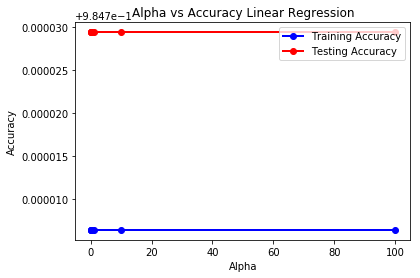

[0.9847063715313567, 0.9847063715313567, 0.9847063715313567, 0.9847063715313567, 0.9847063715313567, 0.9847063715313567, 0.9847063715313567]
[0.9847294069754601, 0.9847294069754601, 0.9847294069754601, 0.9847294069754601, 0.9847294069754601, 0.9847294069754601, 0.9847294069754601]
CPU times: user 9min 26s, sys: 5.15 s, total: 9min 32s
Wall time: 9min 31s


In [16]:
%%time
alpha_arr = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0]
#alpha_arr = [0.01]
train_acc = []
test_acc = []
for a in alpha_arr:    
    classifier = SGDClassifier(loss='log', max_iter=200, tol=1.0e-9, random_state=123, alpha=a)
    classifier.fit(X_train, Y_train)
    # Add to accuracy lists
    train_acc.append(accuracy_score(Y_train, classifier.predict(X_train)))
    test_acc.append(accuracy_score(Y_test, classifier.predict(X_test)))

plt.figure(1)
plt.plot(alpha_arr, train_acc, color='blue', lw=2, marker='o', label="Training Accuracy")
plt.plot(alpha_arr, test_acc, color='red', lw=2, marker='o', label="Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()

print(train_acc)
print(test_acc)

In [17]:
### ONLY USEFUL IF WE USE GRIDSEARCH CV, MIGHT BE TOO SLOW
# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(log_reg_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

# Load data
log_reg_res = {}
with open(log_reg_fn, 'rb') as f:
    log_reg_res = pickle.load(f)

NameError: name 'gs_classifier' is not defined

### Decision Tree

In [21]:
%%time
train_acc = []
test_acc = []
clf = DecisionTreeClassifier(random_state=123)
clf.fit(X_train, Y_train)

train_acc.append(accuracy_score(Y_train, clf.predict(X_train)))
test_acc.append(accuracy_score(Y_test, clf.predict(X_test)))

print(train_acc)
print(test_acc)

[0.9847071831155852]
[0.9847212869111058]
CPU times: user 44.9 s, sys: 537 ms, total: 45.5 s
Wall time: 45.5 s


### Linear SVM

In [ ]:
svm_fn = 'svm_gridsearch_output.pkl'

# Base svm classifier
base_classifier = SGDClassifier(max_iter=1000, tol=1.0e-12, random_state=123)
# Define alpha as param to search over
svm_alpha_arr = np.asarray([0.0001, 0.001, 0.01, 0.1, 1.0])
params = {'alpha': svm_alpha_arr}
# Fit to training data, 5 fold CV
gs_classifier = GridSearchCV(base_classifier, params, scoring='accuracy', cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test)))

# Save output dict just in case
# https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-filew
with open(svm_fn, 'wb') as f:
    pickle.dump(gs_classifier.cv_results_, f)

In [ ]:
# Load data
svm_res = {}
with open(log_reg_fn, 'rb') as f:
    svm = pickle.load(f)
    
plt.figure(1)
plt.plot(svm_alpha_arr, svm_res['mean_train_score'], color='blue', lw=2, marker='o', label="Mean Training Accuracy")
plt.plot(svm_alpha_arr, svm_res['mean_test_score'], color='red', lw=2, marker='o', label="Mean Testing Accuracy")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Alpha vs Accuracy Linear Regression")
plt.legend(loc='upper right')
plt.show()